# 앙상블 학습 개요

# Voting Classifier

## 위스콘시 유방암 데이터 로드

In [5]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pandas as pd

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


## VotingClassifier로 개별 모델은 로지스틱 회귀와 KNN을 보팅방식으로 결합합고 성능 비교

In [7]:
# 개별 모델은 로지스틱 회귀와 KNN임
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 불류기
vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

# VotingClassifier 학습/예측/평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print(f'Voting 분류기 정확도: {accuracy_score(y_test, pred):.4f}')

# 개별 모델의 학습/에측/평가
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print(f'{class_name} 정확도: {accuracy_score(y_test, pred):.4f}')

Voting 분류기 정확도: 0.9474
LogisticRegression 정확도: 0.9386
KNeighborsClassifier 정확도: 0.9386


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

# Random Forest

**결정 트리에서 사용한 사용자 행동 인지 데이터 세트 로딩**

In [8]:
def get_human_dataset():
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당
    feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])

    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = feature_name_df.iloc[:,1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터를 DataFrame으로 로딩, 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/x_train.txt', sep='\s+', header=None)
    X_test = pd.read_csv('./human_activity/test/X_test.txt', sep='\s+', header=None)
    
    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩, 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    X_train.columns = feature_name
    X_test.columns = feature_name
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test

## 학습/테스트 데이터로 분리하고 랜덤 포레스트로 학습/예측/평가

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#결정트리에서 사용한 get_hyuman_dataset()을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 램덤 포레스트 학습 밑 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f'Random Forest accuracy: {accuracy:.4f}')

Random Forest accuracy: 0.9253


## GridSearchCV로 교차검증 및 하이퍼 파라미터 튜닝

In [17]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = get_human_dataset()

params = {
    'n_estimators':[100],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8.16,20]
}

# RandomForestClkassfier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print(f'최적 하이퍼 파라미터: {grid_cv.best_params_}')
print(f'최고 예측 정확도: {grid_cv.best_score_:.4f}')

최적 하이퍼 파라미터: {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 100}
최고 예측 정확도: 0.9169


## 튜닝된 하이퍼 파라미터로 재 학습 및 예측/평가

In [23]:
rf_grid = grid_cv.best_estimator_
rf_grid.fit(X_train, y_train)
pred = rf_grid.predict(X_test)
print(f'예측 정확도: {accuracy_score(y_test, pred):.4f}')

예측 정확도: 0.9267


## 개별 feature들의 중요도 시각화

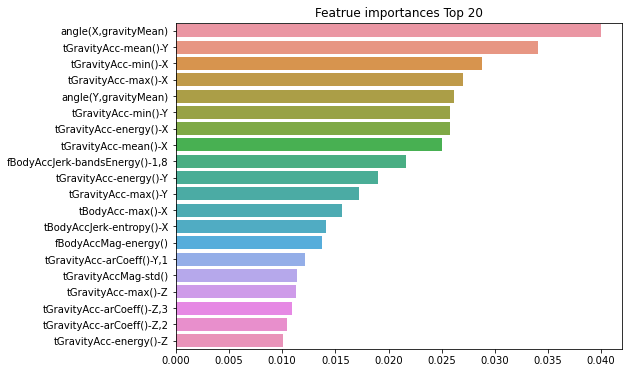

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_grid.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Featrue importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

# GBM(Gradient Boosting Machine)

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위한 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print(f'GBM 정확도: {gb_accuracy:.4f}')
print(f'GBM 수행시간: {time.time() - start_time}')

GBM 정확도: 0.9389
GBM 수행시간: 515.9120712280273


In [28]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100,500],
    'learning_rate':[0.05, 0.1]
}

grid_cv = GridSearchCV(gb_clf, param_grid=params, cv=2, verbose=1)
grid_cv.fit(X_train, y_train)
print(f'최적 하이퍼 파라미터: {grid_cv.best_params_}')
print(f'최고 예측 정확도: {grid_cv.best_score_}')

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 97.5min finished


최적 하이퍼 파라미터: {'learning_rate': 0.1, 'n_estimators': 500}
최고 예측 정확도: 0.9011153427638738


In [29]:
# GridSearchCV를 이용하여 최적으로 학습된 estimator로 predict 수행
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print(f'GBM 정확도: {gb_accuracy:.4f}')

GBM 정확도: 0.9420
